## Amazon Fine Food Reviews - Dakshata Jain, Shilpa Chotwani, Swati Kwatra

#### Printing the output

In [3]:
# print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
pd.set_option('precision', 2) # show only two decimal digits

#### Importing required packages:

In [4]:
import warnings
warnings.filterwarnings("ignore")                                   #Ignoring unnecessory warnings

import numpy as np                                                  #for large and multi-dimensional arrays                               #for data manipulation and analysis
import nltk 
nltk.download('stopwords')                                          #Natural language processing tool-kit
nltk.download('wordnet')

from nltk.corpus import stopwords                                   #Stopwords 
from nltk.stem import PorterStemmer                                 # Stemmer
from nltk.stem import WordNetLemmatizer                             # Lemmatizer

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF  

import seaborn as sns                                                #For Plots                          
%pylab inline

import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus
import mglearn

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shilpu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to /Users/shilpu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Populating the interactive namespace from numpy and matplotlib


<b>References:</b>
https://www.kaggle.com/snap/amazon-fine-food-reviews   

#### Reading the file:

In [5]:
df = pd.read_csv('Reviews.csv')

### Data set description
<li>Each row represents a review(Text) written by a customer(ProfileName) for a specific
product(ProdutId).</li>
<li>The other columns are product rating(score) given by the customer, number of helpful votes for this review(HelpfulnessNumerator) and total votes(HelpfulnessDenominator). A customer can vote the review as helpful or not helpful.</li>
<li>The business problem is to find out the factors that impact the helpfulness of the review.</li>

In [6]:
df.loc[:,['ProductId','ProfileName','Text','Score','HelpfulnessNumerator','HelpfulnessDenominator']].tail(10)

,ProductId,ProfileName,Text,Score,HelpfulnessNumerator,HelpfulnessDenominator
568444,B001EO7N10,"BayBay ""BayBay Knows Best""","As a foodie, I use a lot of Chinese 5 Spice po...",5,3,3
568445,B001EO7N10,S. Linkletter,"You can make this mix yourself, but the Star A...",5,2,2
568446,B001EO7N10,Andy,I had ordered some of these a few months back ...,2,0,0
568447,B001EO7N10,"Real Named Person ""wowzee""","Hoping there is no MSG in this, this tastes ex...",5,0,0
568448,B001EO7N10,James Braley,My only complaint is that there's so much of i...,5,0,0
568449,B001EO7N10,Lettie D. Carter,Great for sesame chicken..this is a good if no...,5,0,0
568450,B003S1WTCU,R. Sawyer,I'm disappointed with the flavor. The chocolat...,2,0,0
568451,B004I613EE,"pksd ""pk_007""","These stars are small, so you can give 10-15 o...",5,2,2
568452,B004I613EE,"Kathy A. Welch ""katwel""",These are the BEST treats for training and rew...,5,1,1
568453,B001LR2CU2,srfell17,"I am very satisfied ,product is as advertised,...",5,0,0


#### Creating the subset: 
<li>Taking only those rows which have been voted (i.e helpful or not) more than 10 times.

In [7]:
df_subset1 = df[(df.HelpfulnessDenominator > 10)]

#### Creating Y variable: (Useful)

In [8]:
#Creating Helpfulness percentage:
df_subset1['Perc_helpfulness'] = (df.HelpfulnessNumerator / df.HelpfulnessDenominator)

In [9]:
#Subsetting further by taking only highly helpful (Perc_helfulness==1) and not at all helpful (Perc_helfulness<0.3):
df_subset2 = df_subset1[(df_subset1.Perc_helpfulness <= 0.4) | (df_subset1.Perc_helpfulness == 1)]

#Creating a dummy variable based on above which defines helpfulness:
df_subset2['Useful'] = (df_subset1.Perc_helpfulness == 1) * 1

In [10]:
df_subset2.loc[:,['ProductId','ProfileName','Text','Score','HelpfulnessNumerator','HelpfulnessDenominator','Perc_helpfulness','Comment_Len','Useful']].head()

,ProductId,ProfileName,Text,Score,HelpfulnessNumerator,HelpfulnessDenominator,Perc_helpfulness,Comment_Len,Useful
32,B001EO5QW8,S. Potter,McCann's Instant Oatmeal is great if you must ...,4,19,19,1.00,NaN,1
33,B001EO5QW8,"Megan ""Bad at Nicknames""",This is a good instant oatmeal from the best o...,4,13,13,1.00,NaN,1
82,B003ZFRKGO,"Johnnycakes ""Johnnycakes""",I know the product title says Molecular Gastro...,5,15,15,1.00,NaN,1
287,B001UJEN6C,Joseph Kagan,"This is a fantastic product, and I wish it was...",5,13,13,1.00,NaN,1
324,B000JEHAHS,"Hurricane Ridge ""Chris""",So we cancelled the order. It was cancelled w...,1,5,19,0.26,NaN,0


####  Creating a feature - length of the review

In [11]:
df_subset1['Comment_Len']= df_subset1['Text'].apply(lambda x: len(str(x).split(' ')))

### CLEANING THE DATA:

#### Cleaning the data by removing duplicates:

In [12]:
# Identifying number of duplicates:
len(df_subset2) - len(df_subset2.groupby(['UserId','Text','ProfileName','Time'])) ### 2288

#Removing duplicates:
df1 = df_subset2.drop_duplicates(subset={"UserId","ProfileName","Time","Text"})

2475

#### Creating a list for stopwords:

In [13]:
#Removing stopwords:
stop = set(stopwords.words('english')) 
print(stop)

{'now', 'me', 'shan', 'himself', 'on', 'further', 'that', "won't", 'under', 'he', 'through', "hasn't", 'where', 'wouldn', 'just', 'if', 'hasn', 'itself', 'yours', 'myself', 'she', 'herself', 's', 'their', "that'll", 'm', 'y', 'ain', "shan't", 'few', 'how', 'what', 'hers', 'couldn', 'the', 'in', 'a', 'as', 'which', 'him', 'when', 'because', 'haven', "isn't", 'below', 'with', 'down', 'above', 'own', "doesn't", 'no', 'hadn', 'theirs', 'who', 'am', 'having', "you've", 'while', 're', 'between', 'have', 'about', 'mightn', 'out', 'those', "mustn't", 'against', 'both', 'here', 'can', 'o', 'did', "hadn't", 'after', 'an', 'so', "wasn't", 'or', 'of', 'didn', 'into', 'all', 'mustn', 'won', 'from', 'once', 'her', 'there', "wouldn't", 'most', 'are', 'my', "shouldn't", 'yourselves', 'needn', 'but', 'ourselves', 'you', 'we', 'them', 'doesn', "you're", "it's", 'i', 'don', 'each', "needn't", 'not', 'has', 'yourself', 'off', "should've", 'some', 'these', 'over', 'and', "you'll", 'before', 'again', 'd', "

In [14]:
#Updating the stopwords by not including words like NOt which are important:
stop_upd = {'here','just', 'before', 'other','whom', 'once', 'further', 'now', 'where',\
            'of', 'below', 'it', 'was','themselves', 't', 'been', 'a', 'had', \
            'when', 'those', 'is', 'your', 'out', "that'll",'he', 'have', 'yourself', \
            'more', 'what', 'which', "she's",'why', 'ours', "you'll", 'they', 've', \
            'after', 'we', 'be', 'being', 'off', 'herself', 'mightn', 'she', 'were', \
            'because', 'for', 'over', 'him', 'the','by','can', 'my', 'haven', 'are', 'd', \
            'and','itself', 'or', 'again', 'them','each', 'theirs', 'these', 'if', 're', \
            'does', 'do', 'than', 'am', 'from', 'only', 'about','in',"it's",'ma','any',  \
            'ourselves', 'some','through', 'ain','such','shan', 'their', 'into','did', 'yours',\
            'up', 'with', 'himself', 'on', 'her', 'm', 'our', 'll', 'under',  "you'd", 'won', 'hers',\
            'then', 'how', 'so', 'i', "you've", 'down', 'that', 'both', 'you', 'there', 'as', 'during', \
            'all', 'own', 'myself', 'above', 'to', 'same', 's', 'but', 'this', 'yourselves', 'his', \
            'until', 'doing', 'who', 'o', 'between', 'at', 'having', 'has', 'y', 'its', 'an', "you're", 'me', 'while'}

#### Cleaning Text (Review) column:

#### Includes Lemmatization: converting the words to their root word which is an actual language word

In [15]:
# Reassigning to df2
df2= df1[~df1.Summary.isna()]

#Cleaning Using Lemmatization:
temp = []
wordnet_lemmatizer = WordNetLemmatizer()

for sentence in df2.Text:
    sentence = sentence.lower()                          # Converting to lowercase
    cleanr   = re.compile('<.*?>')                      
    sentence = re.sub(cleanr, ' ', sentence)             #Removing HTML tags   
    sentence = re.sub('[^a-z ]+',r'',sentence)          #Removing Punctuations, Numbers
    
    words = [wordnet_lemmatizer.lemmatize(word,pos='v') for word in sentence.split() if word not in stop_upd]   # Lemmatizing and removing stopwords
    temp.append(words)
        
X_initial = temp            

In [16]:
#Removing quotes from words:
list_words = []
for row in X_initial:
    s1 = ''
    for word in row:
        s1 = s1 + ' ' + word
    list_words.append(s1)

X_initial = list_words
print(X_initial[0])

 mccanns instant oatmeal great must oatmeal scrape together two three minutes prepare no escape fact however even best instant oatmeal nowhere near good even store brand oatmeal require stovetop preparation still mccanns good get instant oatmeal even better organic allnatural brand try varieties mccanns variety pack taste good prepare microwave add boil water convenient extreme time issue mccanns use actual cane sugar instead high fructose corn syrup help decide buy product real sugar taste better not harmful stuff one thing not like though mccanns use thickeners oats plus water plus heat should make creamy tasty oatmeal without need guar gum convenience product maybe guar gum sit bowl instant mccanns become too thick gluey


### USING SINGLE MATRIX BAG OF WORDS: on Text(Review) Data

In [17]:
#matrix of words 
count_vect = CountVectorizer(max_features=1000,min_df=30)
text_matrix = count_vect.fit_transform(X_initial)

In [18]:
#Converting its output in df:
text_vect = pd.DataFrame(text_matrix.todense(), columns=count_vect.get_feature_names())

In [19]:
#Merging the two dataframes:
df2.index = text_vect.index
df_text = pd.merge(df2, text_vect, left_index=True, right_index=True)

In [20]:
#Converting score column to dummies:
df_text = pd.get_dummies(df_text,columns=['Score'])

In [21]:
#Creating X and Y
X_text = df_text.drop(columns=['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator',\
                    'HelpfulnessDenominator','Time','Summary','Text','Useful','Perc_helpfulness'])
Y_text = df_text.Useful

In [22]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X_text,Y_text,test_size = 0.3,random_state=0)

#### Running a logit model to test the significance of the coefficients:

In [23]:
import statsmodels.api as sm
logit_model=sm.Logit(Y_text,X_text)
result=logit_model.fit(maxiter=10000)
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.176329
         Iterations 11
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.731     
Dependent Variable: Useful           AIC:              4258.8938 
Date:               2019-03-20 19:29 BIC:              11053.1491
No. Observations:   6377             Log-Likelihood:   -1124.4   
Df Model:           1004             LL-Null:          -4182.3   
Df Residuals:       5372             LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     11.0000                                      
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
able              0.6002   0.3950   1.5194 0.1287 -0.1740  1.3744
absolutely       -0.7684   0.4758  -1.6150 0.1063 -1.7009  0.1641

#### Running Logistics Regression:

In [24]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train, Y_train)
y_pred=logreg.predict(X_test)

In [25]:
#Getting the log reg coefficients:
#words = count_vect.get_feature_names()
feature_coefs = pd.DataFrame( data = list(zip(X_text.columns, logreg_result.coef_[0])),columns = ['feature', 'coef']) 
feature_coefs.sort_values(by='coef')

,feature,coef
141,chemicals,-8.07
108,bunch,-7.59
642,possible,-7.54
1001,Score_2,-7.10
633,play,-7.08
585,opinion,-6.98
979,worse,-6.87
935,vinegar,-6.60
471,lemon,-6.51
959,whatever,-6.22


In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test,y_pred)

array([[511, 191],
       [222, 990]])

In [27]:
# Accuracy:
1 - (y_pred - Y_test ).abs().mean()

0.7842215256008359

#### Using gridsearch CV logistics method to find the top 25 features:

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best cross-validation score: 0.88
Best parameters:  {'C': 0.1}
Best estimator:  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


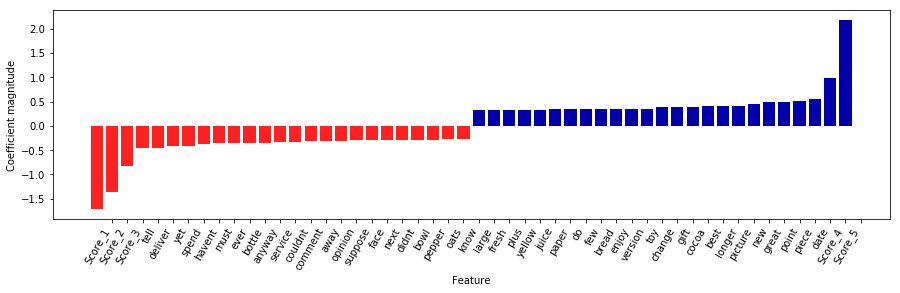

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, Y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

import matplotlib.pyplot as plt
import mglearn
mglearn.tools.visualize_coefficients(grid.best_estimator_.coef_, X_test.columns, n_top_features=25)
plt.show()

### ANALYSIS OF TEXT COLUMN (USING BIGRAM): including combination of bad words

In [29]:
#Reassigning:
Final_X = X_initial 

In [30]:
#Bigram:
count_vect = CountVectorizer(ngram_range=(1,2),min_df=20)
Bigram_data_text = count_vect.fit_transform(Final_X)
print(Bigram_data_text[1])

  (0, 283)	1
  (0, 2595)	1
  (0, 118)	1
  (0, 931)	1
  (0, 2535)	1
  (0, 20)	1
  (0, 2104)	1
  (0, 281)	1
  (0, 1517)	1
  (0, 419)	1
  (0, 124)	1
  (0, 568)	1
  (0, 682)	2
  (0, 1597)	1
  (0, 449)	1
  (0, 973)	1
  (0, 2191)	1
  (0, 673)	2
  (0, 2482)	1
  (0, 509)	1
  (0, 335)	1
  (0, 2615)	1
  (0, 1487)	1
  (0, 1902)	1
  (0, 1745)	1
  (0, 1678)	1
  (0, 2486)	1
  (0, 508)	1
  (0, 1181)	1
  (0, 1290)	1
  (0, 2445)	3
  (0, 334)	1
  (0, 2711)	1
  (0, 2590)	1
  (0, 212)	2
  (0, 2122)	1
  (0, 266)	1
  (0, 1065)	2
  (0, 205)	2
  (0, 2577)	1
  (0, 1097)	1
  (0, 1744)	2
  (0, 1287)	1


In [31]:
#Converting its output in df:
count_vect_df_bigram = pd.DataFrame(Bigram_data_text.todense(), columns=count_vect.get_feature_names())

In [32]:
#Merging the two dataframes:
df2.index = count_vect_df_bigram.index
df3_bigram_merged = pd.merge(df2, count_vect_df_bigram, left_index=True, right_index=True)

In [33]:
#Converting score column to dummies:
df3_bigram = pd.get_dummies(df3_bigram_merged,columns=['Score'])

In [34]:
#Creating X and Y
X = df3_bigram.drop(columns=['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator',\
                    'HelpfulnessDenominator','Time','Summary','Text','Useful','Perc_helpfulness'])
Y = df3_bigram.Useful

In [35]:
#Splitting data into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,Y_training,Y_test = train_test_split(X,Y,test_size = 0.3,random_state=0)

In [36]:
#Running logistics regression:
from sklearn.linear_model import LogisticRegression 
logreg_BG = LogisticRegression(C=1e5) 
logreg_result_BG = logreg_BG.fit(X_train, Y_training) 
y_pred_BG = logreg_result_BG.predict(X_test)

In [37]:
#Getting the log reg coefficients:
feature_coefs = pd.DataFrame( data = list(zip(X.columns, logreg_result_BG.coef_[0])),columns = ['feature', 'coef']) 
feature_coefs.sort_values(by='coef')

,feature,coef
1592,money buy,-11.35
2971,Score_2,-10.37
1983,professional,-10.06
116,anyway,-9.85
115,anytime,-9.62
2970,Score_1,-9.40
885,few days,-8.90
1791,opinion,-8.81
2633,toxic,-8.72
2764,very much,-8.64


In [38]:
# Accuracy:
1 - (y_pred_BG - Y_test ).abs().mean()

0.8040752351097179

In [39]:
import sklearn
sklearn.metrics.precision_score(Y_test,y_pred_BG)

0.8455821635012386

In [40]:
sklearn.metrics.recall_score(Y_test,y_pred_BG)

0.8448844884488449

In [41]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, Y_training)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Best cross-validation score: 0.88
Best parameters:  {'C': 0.1}
Best estimator:  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


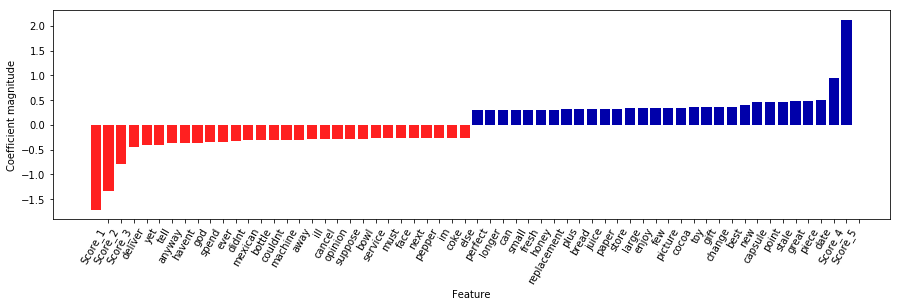

In [42]:
import matplotlib.pyplot as plt

mglearn.tools.visualize_coefficients(grid.best_estimator_.coef_, X.columns, n_top_features=30)
plt.show()

### Process To Analyze The Feature

#### Part 1: Feature : SCORE
<ul>
    <li> From the analysis done above, it can be inferred that, with increase in the product rating, the usefulness increases. However, this seems to be counterintuitive as extreme product rating(1,5) should also have indicated high usefulness.
        <li> For Eg: The review with product rating '1' indicates a strong opinion about the purchase made, thus helping the customer reading the review make an informed decision. This is synonymous in terms of <b>helpfulness</b> with a review with product rating '5'.</li>
    <li> This can be because customers are biased towards marking a review as not useful when they perceive the product quality to be low. This indicates that there is a correlation between the usefulness indicator and product quality</li>

The Score Feature can be validated using the seaborn plot:

In [43]:
import seaborn as sns
%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/Users/shilpu/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


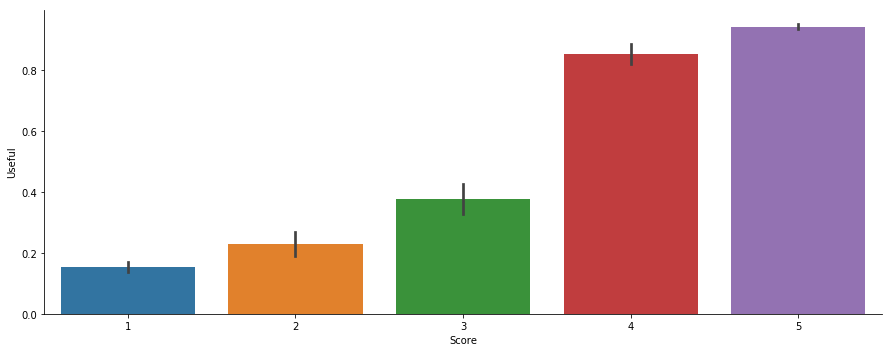

In [44]:
sns.catplot(data=df3_bigram_merged, y = 'Useful',x='Score',
           kind = 'bar',aspect=2.5)

#### Part 2: Feature: Significant Words of Review
<li> Though in general the trend for Usefulness for lower ratings (1,2,3) is decreasing, we look at some of the top features to confirm if they follow the same pattern

<li> Getting the average usefulness of some of the top features (great,best,suppose) for each score/ratings

In [45]:
df_Final = df3_bigram_merged[['Score','Useful','great','best','suppose']]
df_Final['Binned_Score_less_than_3'] = (df_Final.Score <= 3 ) * 1

In [46]:
df_1 = df_Final[(df_Final.great < 2 )]
df_1.groupby(['great','Score'])['Useful'].mean()

great  Score
0      1        0.15
       2        0.23
       3        0.36
       4        0.82
       5        0.93
1      1        0.23
       2        0.25
       3        0.45
       4        0.95
       5        0.98
Name: Useful, dtype: float64

In [47]:
df_2 = df_Final[(df_Final.best < 2 )]
df_2.groupby(['best','Score'])['Useful'].mean()

best  Score
0     1        0.15
      2        0.23
      3        0.38
      4        0.84
      5        0.93
1     1        0.32
      2        0.24
      3        0.38
      4        0.94
      5        0.97
Name: Useful, dtype: float64

In [48]:
df_3 = df_Final[(df_Final.suppose < 2 )]
df_3.groupby(['suppose','Score'])['Useful'].mean()

suppose  Score
0        1        0.16
         2        0.23
         3        0.38
         4        0.86
         5        0.94
1        1        0.14
         2        0.09
         3        0.29
         4        0.69
         5        0.98
Name: Useful, dtype: float64

## Finding
<ul>
<li> If the rating is greater than 4, the appearance of any word does not significantly impact the usefulness </li>
<li> However, if the review has opinion words  like 'great','best' etc., then with the appearance of the words, the usefulness seems to increase even if the product rating provided is lower </li>
<li> Also, if the words are neutral and ambiguous like 'suppose','anyway' etc. the usefulness seems to decrease with the appearance of the word

The following graphs can validate the above finding:

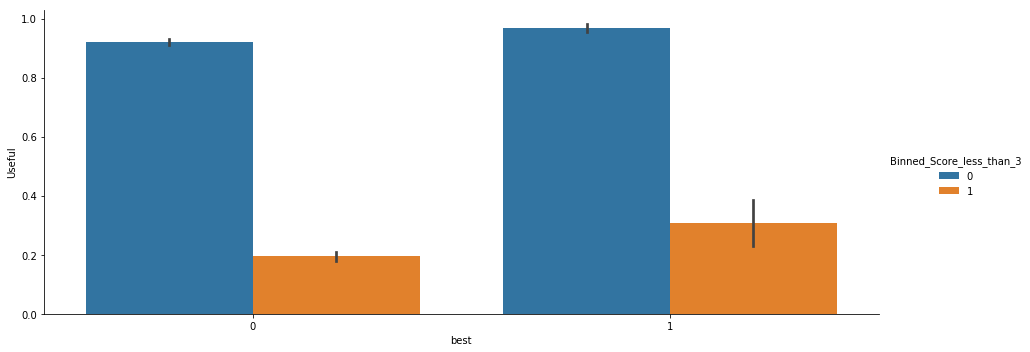

In [49]:
sns.catplot(data=df_2, y = 'Useful',x='best',
           kind = 'bar',aspect=2.5, hue = 'Binned_Score_less_than_3')

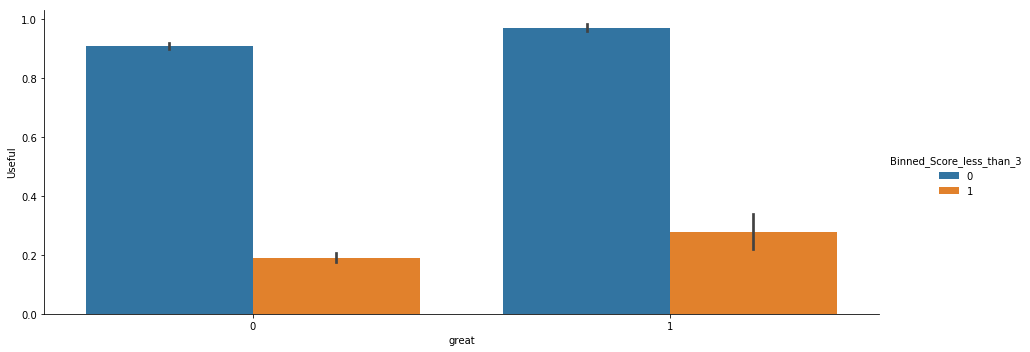

In [50]:
sns.catplot(data=df_1, y = 'Useful',x='great',
           kind = 'bar',aspect=2.5, hue = 'Binned_Score_less_than_3')

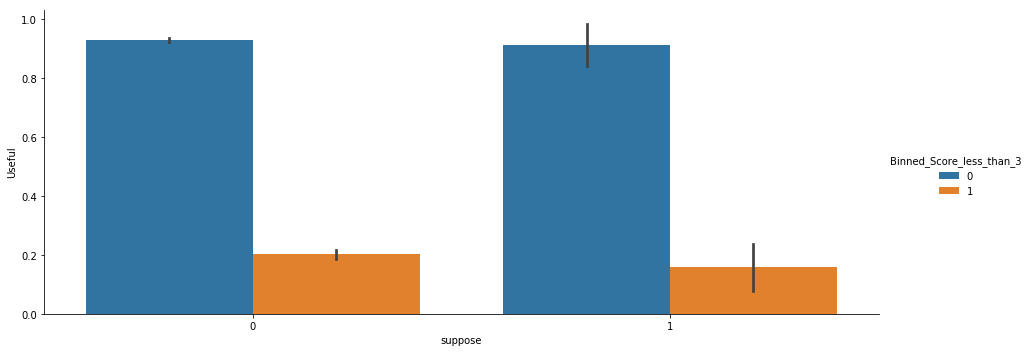

In [51]:
sns.catplot(data=df_3, y = 'Useful',x='suppose',
           kind = 'bar',aspect=2.5, hue = 'Binned_Score_less_than_3')

### Managerial Insights

<li> From our finding, we conclude that positioning of reviews can be changed so that they are most useful to the customers and can help them make better decisions. For example, the reviews with highest rating and with contain superlative words should be displayed on the top</li>
<li> As the customers are correlating the helpfulness and low product rating, the option to vote not helpful should be removed as it is resulting in biased information. </li>

### Machine Learning Mastery
<ul>
    <b>Feature Engineering</b>:
        <li>Countvectorizer: We used BIGRAM technique to convert the words and the pair of adjacent words into independent columns which reflects the number of times they appeared in the review. Only those words which appeared in more than 20 reviews were considered.</li>
    <li> Score : We created Dummy variables for the Score variable to find the impact of each Score Level on Usefulness</li>
    <li> Comment Length: Total number of words in each review.</li>
    <li> Useful : This dependent variable indicates whether a review is helpful or not. For analysis only those review which were voted highly helpful and least helpful were considered.</li>
    
   <b>Logistic Regression:</b>
    <li> The above features and score were considered in the logistics regression used to identify the columns that significantly impact the helpfulness of a review. Gridsearch CV method was used to identify the top 25 features.</li>